<p style="display:flex; align-items:center;">
  <img src="https://upload.wikimedia.org/wikipedia/it/1/11/Napoli_university_seal_alfachannel.png"
       alt="Logo UNINA" width="10%" style="margin-right:2%;">
  <img src="https://indico.unina.it/event/58/attachments/172/352/logo_dieti.png"
       alt="Logo DIETI" width="10%">
</p>


# Guided-Supervised Anomaly Detection using Machine Learning, Deep Learning, and Generative AI

---

***Practical Network Intrusion Detection with Machine Learning and Generative AI***

Prof. Giampaolo Bovenzi


In [1]:
# Colab bootstrap
import os, sys, subprocess, importlib, pathlib

REPO_URL = "https://github.com/jmpr0/practical-nids"
REPO_DIR = "/content/practical-nids"

if not pathlib.Path(REPO_DIR).exists():
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

os.chdir(REPO_DIR)

# Install deps
subprocess.run([sys.executable, "-m", "pip", "install", "-r", "requirements.txt", "--quiet"], check=True)

# Create outputs dirs
for d in ["outputs", "data/cache", "models"]:
    pathlib.Path(d).mkdir(parents=True, exist_ok=True)

print("Setup OK in", os.getcwd())


Setup OK in /content/practical-nids


## Data Loader Module
This module handles loading and preprocessing of datasets for anomaly detection.

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from functools import partial
import scipy.stats
from statsmodels import robust
from tqdm import tqdm
from glob import glob

# Data Loading
def load_data(dataset_name='kdd', num_packets=20, seed=0, validation_split=0.1):

  if dataset_name == 'kdd':

    train_fn = os.path.join(data_dir, 'NSL-KDD/KDDTrain+.txt')
    test_fn = os.path.join(data_dir, 'NSL-KDD/KDDTest+.txt')
    df_train = pd.read_csv(train_fn, header=None)
    df_test = pd.read_csv(test_fn, header=None)

    X_train, y_train = df_train.iloc[:, :-2].to_numpy(), df_train.iloc[:, -2].to_numpy()
    X_test, y_test = df_test.iloc[:, :-2].to_numpy(), df_test.iloc[:, -2].to_numpy()

  elif dataset_name == 'iot-23':

    base_path = os.path.join(data_dir, 'IoT-23')
    path = os.path.join(base_path, f'iot23-stats_{num_packets}-pkts.parquet')

    df = pd.read_parquet(path)
    X, y = df.iloc[:, :-1].to_numpy(), df.iloc[:, -1].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)

  X_val, y_val = None, None
  if validation_split:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split, stratify=y_train, random_state=seed)

  return X_train, y_train, X_test, y_test, X_val, y_val

# Data Preprocessing
def preprocess_data(X_train, y_train, X_test, y_test, X_val=None, y_val=None, dataset_name='kdd'):

  if dataset_name == 'kdd':

    cat_indexes = [i for i, v in enumerate(X_train[0]) if isinstance(v, str)]
    for cat_index in cat_indexes:
      oe = OrdinalEncoder()
      X_train[:, cat_index] = oe.fit_transform(X_train[:, cat_index].reshape(-1, 1)).squeeze()
      if X_val is not None:
        X_val[:, cat_index] = oe.transform(X_val[:, cat_index].reshape(-1, 1)).squeeze()
      X_test[:, cat_index] = oe.transform(X_test[:, cat_index].reshape(-1, 1)).squeeze()
    legitimate_class = 'normal'

  else:  # dataset_name == 'iot-23'

    legitimate_class = 'Benign'

  # Normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  if X_val is not None:
    X_val = scaler.transform(X_val)

  # Encode labels
  label_encoder = LabelEncoder().fit(np.concatenate((y_train, y_test)))
  y_train = label_encoder.transform(y_train)
  y_test = label_encoder.transform(y_test)
  if y_val is not None:
    y_val = label_encoder.transform(y_val)

  encoded_legit_class = label_encoder.transform([legitimate_class])[0]

  return X_train, y_train, X_test, y_test, X_val, y_val, encoded_legit_class


## Utils Module
This module contains utility functions and callbacks to assist with training.

In [ ]:
from time import process_time
from tensorflow.keras.callbacks import Callback

class TimeEpochs(Callback):
  """Callback to measure per-epoch training time."""

  def __init__(self):
    super().__init__()
    self.epoch_time_start = None

  def on_epoch_begin(self, epoch, logs=None):
    self.epoch_time_start = process_time()

  def on_epoch_end(self, epoch, logs=None):
    if logs is not None:
      logs['time'] = process_time() - self.epoch_time_start


## Plotting Module
This module provides visualization functions to assess model performance.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_roc(y_true, y_score, savefig=None, show=True, dpi=300, colors=('firebrick', 'black')):
  """
  Plots the ROC curve.

  Parameters:
  - y_true: array-like, ground truth binary labels.
  - y_score: array-like, predicted scores or probabilities.
  - savefig: str or None, base filename to save the figure (without extension).
  - show: bool, whether to display the plot (default: True).
  - dpi: int, resolution for saving the figure (default: 300).
  - colors: tuple, (ROC curve color, diagonal line color).
  """

  fpr, tpr, _ = roc_curve(y_true, y_score)

  fig, ax = plt.subplots(figsize=(5, 3))
  ax.plot(fpr, tpr, color=colors[0], label="ROC Curve", zorder=4, clip_on=False)
  ax.plot([0, 1], [0, 1], color=colors[1], linestyle='--', label="Random Guess", zorder=3)

  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])
  ax.set_xlabel('False Positive Rate (FPR)')
  ax.set_ylabel('True Positive Rate (TPR)')
  ax.legend()
  plt.tight_layout()

  # Save figure in multiple formats if savefig is provided
  if savefig:
    for ext in ['pdf', 'png']:
      plt.savefig(f"{savefig}.{ext}", dpi=dpi, bbox_inches='tight')

  # Show the plot if enabled
  if show:
    plt.show()

  plt.close(fig)  # Prevents memory leaks in long-running scripts


## Disk Logger Module
This module manages logging of results and outputs to disk.

In [ ]:
import json
import sys
import os

class FileOutputDuplicator:
  """A class that duplicates stdout/stderr output to a file."""

  def __init__(self, duplicate, fname, mode='w'):
    self.file = open(fname, mode)
    self.duplicate = duplicate

  def __del__(self):
    """Ensure the file is closed properly when the object is destroyed."""
    if self.file and not self.file.closed:
      self.file.close()

  def write(self, data):
    """Write data to both file and duplicate stream."""
    self.file.write(data)
    self.duplicate.write(data)
    self.flush()

  def flush(self):
    """Flush both file and duplicate output stream."""
    self.file.flush()
    self.duplicate.flush()

class DiskLogger:
  """Handles logging to disk, including argument saving and stdout/stderr redirection."""

  def __init__(self, results_path):
    """Initialize with the results path where logs will be stored."""
    self.results_path = results_path
    os.makedirs(results_path, exist_ok=True)

  def log_args(self, args, filename='args.log'):
    """Save experiment arguments to a JSON file."""
    log_path = os.path.join(self.results_path, filename)
    try:
      with open(log_path, 'w') as f:
        json.dump(args, f, indent=2)
    except Exception as e:
      print(f"Error saving args log: {e}", file=sys.stderr)

  def log_stdout(self, filename='stdout.log'):
    """Redirect stdout to a file while maintaining console output."""
    sys.stdout = FileOutputDuplicator(sys.stdout, os.path.join(self.results_path, filename))

  def log_stderr(self, filename='stderr.log'):
    """Redirect stderr to a file while maintaining console output."""
    sys.stderr = FileOutputDuplicator(sys.stderr, os.path.join(self.results_path, filename))


## Detector Base Class
This base class defines a common interface for all anomaly detectors.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model

class Detector:
  """A general anomaly detector using TensorFlow/Keras models."""

  def __init__(self):
    self.model = None

  def compile(self, **kwargs):
    """Compile the Keras model with the given optimizer and loss function."""
    if self.model:
      self.model.compile(**kwargs)

  def fit(self, X, y, **kwargs):
    """Train the model with input features X and target y."""
    if self.model:
      self.model.fit(X, y, **kwargs)

  def predict(self, X, **kwargs):
    """Generate predictions from the trained model."""
    return self.model.predict(X, **kwargs) if self.model else None

  def score(self, X, **kwargs):
    """Calculate the root mean squared error (RMSE) as an anomaly score."""
    X_pred = self.predict(X, **kwargs)
    if X_pred is not None:
      return np.sqrt(np.mean((X - X_pred) ** 2, axis=1))  # Vectorized RMSE
    return None

  def print_summary(self):
    """Prints the model architecture summary."""
    if self.model:
      self.model.summary()


## Shallow Autoencoder (AE)
This is a simple autoencoder used for anomaly detection.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model


class AE(Detector):
  def __init__(self, input_size, red_fact=0.5, encoder_activation='relu', decoder_activation='sigmoid'):
    """Creates an Autoencoder model inside the Detector class.

    Parameters:
    - input_size (int): Number of input features.
    - red_fact (float): Reduction factor for encoding layer size (default: 0.5).
    - encoder_activation (str): Activation function for encoder layer (default: 'relu').
    - decoder_activation (str): Activation function for decoder layer (default: 'sigmoid').
    """
    super().__init__()

    reduced_size = int(np.ceil(input_size * red_fact))

    # Define autoencoder architecture
    inputs = Input(shape=(input_size,))
    encoded = Dense(reduced_size, activation=encoder_activation)(inputs)
    encoded = Dropout(0.2)(encoded)
    decoded = Dense(input_size, activation=decoder_activation)(encoded)

    # Assign model to self.model
    self.model = Model(inputs, decoded)


## Deep Autoencoder (DeepAE)
This is a deep autoencoder for better feature extraction in anomaly detection.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

class DAE(Detector):
  def __init__(self, input_size, red_fact=[0.75, 0.5], encoder_activation='relu', decoder_activation='relu', final_activation='sigmoid'):
    """Creates a Deep Autoencoder inside the Detector class.

    Parameters:
    - input_size (int): Number of input features.
    - red_fact (list of float): List of reduction factors for encoder layers.
    - encoder_activation (str): Activation function for encoder layers (default: 'relu').
    - decoder_activation (str): Activation function for decoder layers (default: 'relu').
    - final_activation (str): Activation function for the final decoder layer (default: 'sigmoid').
    """
    super().__init__()

    # Compute encoder and decoder sizes
    encoder_sizes = [int(np.ceil(input_size * rf)) for rf in red_fact]
    decoder_sizes = encoder_sizes[::-1][1:]  # Exclude the last encoder size

    # Define encoder layers
    inputs = Input(shape=(input_size,))
    x = inputs
    for size in encoder_sizes:
      x = Dense(size, activation=encoder_activation)(x)

    # Define decoder layers
    for size in decoder_sizes:
      x = Dense(size, activation=decoder_activation)(x)

    # Final output layer
    x = Dropout(0.2)(x)
    outputs = Dense(input_size, activation=final_activation)(x)

    self.model = Model(inputs, outputs)


## KitNET Anomaly Detector
This is the KitNET anomaly detection model, which is an ensemble of shallow autoencoders.

In [ ]:
import numpy as np
from tensorflow.keras.models import Model

class KitNET(Detector):
  def __init__(self, input_size, k=5):
    """Creates a KitNET anomaly detection model with multiple autoencoders."""
    super().__init__()

    self.k = k

    # Determine input sizes for each ensemble autoencoder
    base_size = input_size // k
    self.input_sizes = [base_size + (1 if i < input_size % k else 0) for i in range(k)]

    # Precompute feature indices using NumPy
    self.splits = np.cumsum(self.input_sizes)[:-1]

    # Initialize autoencoder ensemble and output autoencoder
    self.ensemble = [AE(size) for size in self.input_sizes]
    self.output = AE(self.k)

  def compile(self, **kwargs):
    """Compile all autoencoders."""
    for ae in self.ensemble:
      ae.compile(**kwargs)
    self.output.compile(**kwargs)

  def fit(self, X, y, **kwargs):
    """Train all ensemble autoencoders and the final output autoencoder."""
    verbose = kwargs.get('verbose', False)
    X_splits = np.split(X, self.splits, axis=1)
    y_splits = np.split(y, self.splits, axis=1)
    y_score = np.zeros((X.shape[0], self.k))

    filenames_per_callback = {}

    for i, (X_sub, y_sub, ae) in enumerate(zip(X_splits, y_splits, self.ensemble)):
      if verbose:
        print(f'Training autoencoder {i + 1} / {self.k}...')

      # Modify callback filenames if applicable
      for callback in kwargs.get('callbacks', []):
        if hasattr(callback, 'filename') and isinstance(callback.filename, str):
          filename = filenames_per_callback.setdefault(callback.__class__.__name__, callback.filename)
          callback.filename = filename.replace('.csv', f'_{i}.csv')

      ae.fit(X_sub, y_sub, **kwargs)

      if verbose:
        print(f'Inferring autoencoder {i + 1} / {self.k}...')

      y_score[:, i] = ae.score(X_sub)

    if verbose:
      print('Training output autoencoder...')

    # Normalize and train the final output autoencoder
    y_score /= np.sum(y_score, axis=1, keepdims=True)
    self.output.fit(y_score, y_score, **kwargs)

  def score(self, X, **kwargs):
    """Compute anomaly scores using ensemble autoencoders and output autoencoder."""
    verbose = kwargs.get('verbose', False)
    X_splits = np.split(X, self.splits, axis=1)
    y_score = np.zeros((X.shape[0], self.k))

    for i, (X_sub, ae) in enumerate(zip(X_splits, self.ensemble)):
      if verbose:
        print(f'Inferring autoencoder {i + 1} / {self.k}...')

      y_score[:, i] = ae.score(X_sub)

    if verbose:
      print('Inferring output autoencoder...')

    y_score /= np.sum(y_score, axis=1, keepdims=True)
    return self.output.score(y_score, **kwargs)

  def print_summary(self):
    """Print summaries for all autoencoders."""
    for ae in self.ensemble:
      ae.print_summary()
    self.output.print_summary()


# Anomaly Detection via Deep Learning

In [ ]:
!pip install livelossplot

In [ ]:
from time import time
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from livelossplot.tf_keras import PlotLossesCallback


In [ ]:
import random
import numpy as np
import tensorflow as tf
import os

seed = 42

# Set Python's built-in random seed
random.seed(seed)
# Set NumPy seed
np.random.seed(seed)
# Set TensorFlow seed
tf.random.set_seed(seed)

# Ensure TensorFlow uses deterministic operations (for GPU computations)
os.environ["PYTHONHASHSEED"] = str(seed)  # Fix hash-based randomness
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # Force deterministic operations
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"  # Use deterministic cuDNN algorithms


In [ ]:
import os
from time import time

# Set training parameters (previously argparse arguments)
model_name = 'deepautoencoder'     # Model choice
model_class = DAE               # Model class
noise_std = 0.0           # Noise standard deviation for training robustness
batch_size = 128          # Batch size for training
epochs = 10               # Number of training epochs
validation_split = 0.1    # Fraction of training data used for validation
patience = 5              # Early stopping patience (number of epochs without improvement)
results_path = './results'  # Base directory to save results
dataset_name = 'kdd'      # Name of the dataset (i.e., 'kdd' and 'iot-23)

# Generate a timestamped results directory for experiment tracking
timestamp = f"{model_name}_{int(time())}"
results_path = os.path.join(results_path, timestamp)

# Create the results directory if it does not exist
os.makedirs(results_path, exist_ok=True)


In [ ]:
# Initialize the disk logger to save experiment details
logger = DiskLogger(results_path)

# Log experiment hyperparameters and configurations
experiment_config = {
    'model_name': model_name,           # Name of the selected model
    'noise_std': noise_std,             # Standard deviation of noise added to training data
    'batch_size': batch_size,           # Batch size for training
    'epochs': epochs,                   # Total number of training epochs
    'validation_split': validation_split,  # Fraction of training data used for validation
    'patience': patience,               # Patience for early stopping
    'results_path': results_path        # Path where logs and results will be saved
}

logger.log_args(experiment_config)


In [ ]:
# Load the dataset and preprocess it
print("Loading data...")
X_train, y_train, X_test, y_test, X_val, y_val = load_data(
    dataset_name=dataset_name, validation_split=validation_split)

print("Processing data...")
X_train, y_train, X_test, y_test, X_val, y_val, encoded_legit_class = preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    dataset_name=dataset_name
)

# Filter out only the "normal" data points for training
# This ensures the model learns from legitimate (non-anomalous) data
X_train = X_train[np.where(y_train == encoded_legit_class)]
if X_val is not None:
  X_val = X_val[np.where(y_val == encoded_legit_class)]

# Introduce noise to the training data (if applicable)
# This helps with robustness and generalization in anomaly detection
X_train_noise = np.random.normal(0, noise_std, X_train.shape)

# Print class distribution in training and test sets
# Helps verify that data preprocessing was done correctly
print("Train info:", np.unique(y_train, return_counts=True))
print("Test info:", np.unique(y_test, return_counts=True))


Loading data...
Processing data...
Train info: (array([ 1,  2,  3,  4,  6,  7,  8,  9, 12, 14, 15, 16, 17, 18, 19, 20, 23,
       25, 27, 30, 32, 34, 35]), array([  860,    27,     7,    48,    10,  3239,    16,     8,     6,
       37092,  1344, 60608,     3,     4,   181,  2638,     9,  3270,
        2381,     2,   803,   801,    18]))
Test info: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35,
       36, 37, 38, 39]), array([ 737,  359,   20,    3, 1231,  133,    1,  141,    7,    2,  293,
        996,   18,   17, 4657,   73, 9711,    2,    2,   41,  157,  685,
         15,   13,  319,  735,   14,  665,  178,  331,    2,   12,    2,
        944,    2,    9,    4,   13]))


In [ ]:
print('Percentage of legitimate traffic: %.2f' % (sum([t == encoded_legit_class for t in y_train]) / len(y_train) * 100), '%')
print('Percentage of non-legitimate traffic: %.2f' % (sum([t != encoded_legit_class for t in y_train]) / len(y_train) * 100), '%')

Percentage of legitimate traffic: 53.46 %
Percentage of non-legitimate traffic: 46.54 %


In [ ]:
# Initialize and build the anomaly detection model
print("Building model...")

# Dynamically create the model instance using the specified model name
# `globals()[model_name]` retrieves the function/class with the given name
# and passes the input size (X_train.shape[1]) as an argument.
detector = model_class(X_train.shape[1])

# Compile the model with specified optimizer and loss function
# - `optimizer='sgd'`: Uses Stochastic Gradient Descent (SGD) for training
# - `loss='mse'`: Mean Squared Error (MSE) is commonly used in autoencoders
detector.compile(optimizer='sgd', loss='mse')

# Print the model summary to check its architecture
detector.print_summary()


Building model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 41)]              0         
                                                                 
 dense (Dense)               (None, 31)                1302      
                                                                 
 dense_1 (Dense)             (None, 21)                672       
                                                                 
 dense_2 (Dense)             (None, 31)                682       
                                                                 
 dropout (Dropout)           (None, 31)                0         
                                                                 
 dense_3 (Dense)             (None, 41)                1312      
                                                                 
Total params: 3968 (15.50 KB)
Trainable par

In [ ]:
!pip install pydot
# Execute in terminal: sudo apt install graphviz

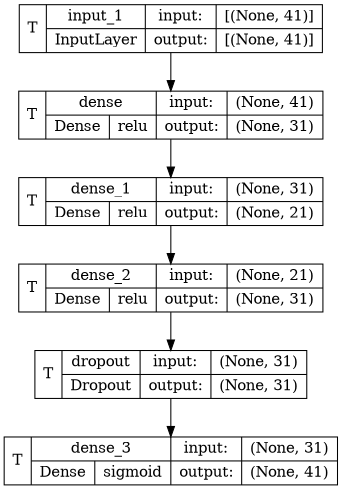

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# if model_name in ['autoencoder', 'deepautoencoder']:
#   plot_model(detector.model, show_shapes=True, show_layer_names=True, show_trainable=True, show_layer_activations=True, dpi=75)
#   plt.show()
# else:  # if detector_name == 'kitnet'
#   for model in detector.ensemble:
#     plot_model(detector, show_shapes=True, show_layer_names=True, show_trainable=True, show_layer_activations=True, dpi=75)
#     plt.show()
#   plot_model(detector.output, show_shapes=True, show_layer_names=True, show_trainable=True, show_layer_activations=True, dpi=75)
#   plt.show()

plot_model(detector.model, show_shapes=True, show_layer_names=True, show_trainable=True, show_layer_activations=True, dpi=75)

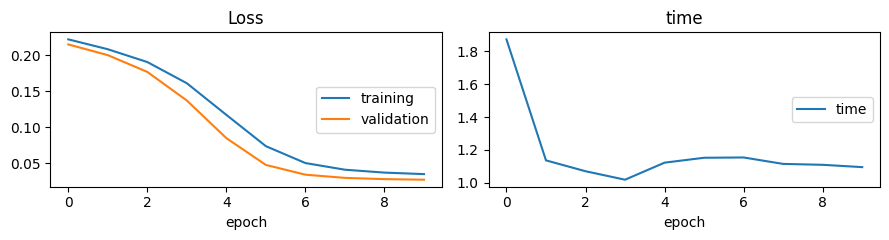

Loss
	training         	 (min:    0.035, max:    0.222, cur:    0.035)
	validation       	 (min:    0.027, max:    0.215, cur:    0.027)
time
	time             	 (min:    1.019, max:    1.872, cur:    1.095)
474/474 [==============================] - 1s 2ms/step - loss: 0.0352 - val_loss: 0.0274 - time: 1.0953
Fit completed in 18.915 s.


In [ ]:
# Initialize a list to store callbacks
callbacks = []

# If validation split is used, warn the user and enable EarlyStopping
if validation_split > 0:
  print("WARNING: validation_split is used as validation.")
  # EarlyStopping: Stops training if `val_loss` does not improve for `patience` epochs
  callbacks.append(EarlyStopping(monitor='val_loss', patience=patience))

# Add additional callbacks for logging and tracking training time
callbacks.extend([
  TimeEpochs(),  # Tracks per-epoch execution time
  CSVLogger(f"{results_path}/log.csv", append=True),  # Logs training progress to a CSV file
  PlotLossesCallback(mode='notebook', figsize=(9, 2.5)),
])

# Start model training
print("Fitting model...")
start_time = process_time()  # Record start time for measuring training duration

# Train the model with the given dataset and specified hyperparameters
detector.fit(
  X_train + X_train_noise,  # Injecting noise into training data for robustness
  X_train,  # Target output is the original training data (autoencoder setup)
  batch_size=batch_size,
  epochs=epochs,
  validation_data=(X_val, X_val),  # Uses a fraction of training data for validation
  callbacks=callbacks,  # Passes callback functions for early stopping and logging
  verbose=1  # Displays training progress
)

# Display total training time
print(f"Fit completed in {process_time() - start_time:.3f} s.")


In [ ]:
# Start model inference on the test dataset
print("Test inferring...")

# Record the start time to measure inference duration
start_time = process_time()

# Compute anomaly scores for the test set
# - `detector.score(X_test)`: Uses the trained model to predict anomaly scores
# - `verbose=1`: Prints progress if enabled
y_score = detector.score(X_test, verbose=1)

# Display total inference time and number of test instances processed
print(f"Inference of {len(y_score)} instances completed in {process_time() - start_time:.3f} s.")


Test inferring...
705/705 [==============================] - 1s 1ms/step
Inference of 22544 instances completed in 1.477 s.


In [ ]:
# Save test inference results
print("Saving results...")

# Create a DataFrame to store true labels and predicted anomaly scores
df_output = pd.DataFrame({
    'y_true': y_test.astype(int),  # Convert true labels to integers
    'y_score': y_score             # Store anomaly scores
})

# Save the results as a Parquet file for efficient storage
df_output.to_parquet(os.path.join(results_path, 'targets_scores.parquet'))

# Perform inference on the training data
print("Train inferring...")
y_score_train = detector.score(X_train, verbose=1)

# Create a DataFrame for training scores
df_output_train = pd.DataFrame({'y_score': y_score_train})

# Save the training scores to a Parquet file
df_output_train.to_parquet(os.path.join(results_path, 'train_scores.parquet'))

if X_val is not None:
  # Perform inference on the training data
  print("Validation inferring...")
  y_score_val = detector.score(X_val, verbose=1)

  # Create a DataFrame for training scores
  df_output_val = pd.DataFrame({'y_score': y_score_val})

  # Save the training scores to a Parquet file
  df_output_val.to_parquet(os.path.join(results_path, 'val_scores.parquet'))


Saving results...
Train inferring...
1894/1894 [==============================] - 2s 1ms/step
Validation inferring...
211/211 [==============================] - 0s 2ms/step


Plotting ROC curve...


ROC AUC Score: 0.9017
ROC Partial AUC Score: 0.6688


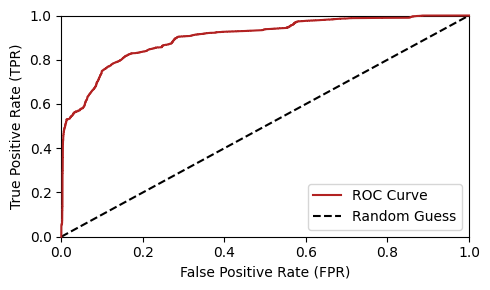

In [ ]:
from sklearn.metrics import roc_auc_score

# Generate and save the ROC curve
print("Plotting ROC curve...")

# Convert `y_test` into binary format:
# - Assign `0` for the legitimate class (`encoded_legit_class`).
# - Assign `1` for anomalies (all other classes).
y_test_binary = [0 if v == encoded_legit_class else 1 for v in y_test.astype(int)]

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_score)
print(f'ROC AUC Score: {roc_auc:.4f}')
roc_pauc = roc_auc_score(y_test_binary, y_score, max_fpr=0.01)
print(f'ROC Partial AUC Score: {roc_pauc:.4f}')

# Plot the ROC curve and save it as a figure
plot_roc(
    y_test_binary,  # Ground truth binary labels
    y_score,        # Predicted anomaly scores
    savefig=os.path.join(results_path, f'ROC_{model_name}')  # Save as file
)


TPR-FPR @thr=avg: 0.91-0.33
TPR-FPR @thr=avg+std: 0.76-0.11



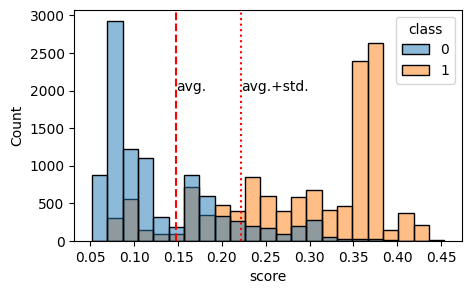

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

hist_data = pd.DataFrame(columns=['score', 'class'])
hist_data['score'] = y_score
hist_data['class'] = y_test_binary

fig, ax = plt.subplots(figsize=(5, 3))

sns.histplot(hist_data, x='score', hue='class', stat='count', ax=ax)

# Compute thresholds
thr_avg = np.mean(y_score_val)
thr_avg_std = thr_avg + np.std(y_score_val)

# Convert y_test_binary to NumPy array (avoid redundant calls)
y_test_binary = np.array(y_test_binary)

# Compute FPR and TPR at threshold avg
tp_thr_avg = np.sum(y_test_binary[y_score >= thr_avg])  # True Positives
fp_thr_avg = np.sum((1 - y_test_binary)[y_score >= thr_avg])  # False Positives
tpr_thr_avg = tp_thr_avg / np.sum(y_test_binary)  # True Positive Rate
fpr_thr_avg = fp_thr_avg / np.sum(1 - y_test_binary)  # False Positive Rate

# Compute FPR and TPR at threshold avg+std
tp_thr_avg_std = np.sum(y_test_binary[y_score >= thr_avg_std])  # True Positives
fp_thr_avg_std = np.sum((1 - y_test_binary)[y_score >= thr_avg_std])  # False Positives
tpr_thr_avg_std = tp_thr_avg_std / np.sum(y_test_binary)  # True Positive Rate
fpr_thr_avg_std = fp_thr_avg_std / np.sum(1 - y_test_binary)  # False Positive Rate

# Print Corrected Metrics
print(f'TPR-FPR @thr=avg: {tpr_thr_avg:.2f}-{fpr_thr_avg:.2f}')
print(f'TPR-FPR @thr=avg+std: {tpr_thr_avg_std:.2f}-{fpr_thr_avg_std:.2f}')
print()

ax.axvline(x=thr_avg, color='red', linestyle='--', label='avg.')
ax.axvline(x=thr_avg_std, color='red', linestyle=':', label='avg.+std.')
ax.text(x=thr_avg, y=2e3, s='avg.')
ax.text(x=thr_avg_std, y=2e3, s='avg.+std.')

plt.show()
plt.close()

## Deep AutoEncoder with pyOD

In [ ]:
!pip install pyod==2.0.5

Training: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


ROC AUC Score: 0.9354
ROC Partial AUC Score: 0.5153


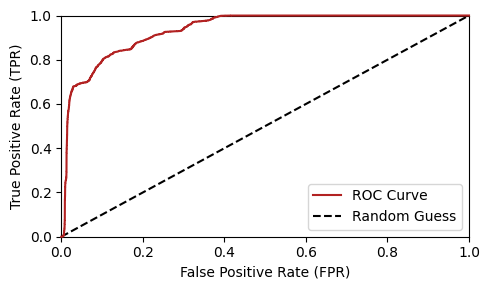

In [ ]:
import os
import numpy as np
from pyod.models.auto_encoder import AutoEncoder
from sklearn.metrics import roc_auc_score
import math

# Initialize and train the AE model
ae = AutoEncoder(contamination=0.01, preprocessing=True,
                  lr=0.01,
                  epoch_num=10,
                  batch_size=128, optimizer_name='sgd', device=None, random_state=42,
                  use_compile=False, compile_mode='default', verbose=1,
                  hidden_neuron_list=[
                      math.ceil(X_train.shape[1] * .75),
                      math.ceil(X_train.shape[1] * .5)],
                  hidden_activation_name='relu',
                  batch_norm=False, dropout_rate=0)

# contamination=0.1, preprocessing=True, lr=0.001, epoch_num=10,
# batch_size=32, optimizer_name='adam', device=None, random_state=42,
# use_compile=False, compile_mode='default', verbose=1,
# optimizer_params={'weight_decay': 1e-05},
# hidden_neuron_list=[64, 32], hidden_activation_name='relu',
# batch_norm=True, dropout_rate=0.2

ae.fit(X_train)

# Extract AE raw scores (higher score = more anomalous)
y_score = ae.decision_function(X_test)  # Raw anomaly scores

# Convert y_test to binary format if necessary (ensure it's 0 or 1)
y_test_binary = [0 if v == encoded_legit_class else 1 for v in y_test.astype(int)]

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_score)
print(f'ROC AUC Score: {roc_auc:.4f}')
roc_pauc = roc_auc_score(y_test_binary, y_score, max_fpr=0.01)
print(f'ROC Partial AUC Score: {roc_pauc:.4f}')

# Define the save path (modify `results_path` and `model_name` accordingly)
results_path = "./results"  # Change this to your preferred directory
model_name = "AE"
os.makedirs(results_path, exist_ok=True)

# Plot and save the ROC curve
plot_roc(
    y_test_binary,
    y_score,
    savefig=os.path.join(results_path, f'ROC_{model_name}')
)


# Anomaly Detection via Machine Learning

## Isolation Forest with pyOD

ROC AUC Score: 0.9424
ROC Partial AUC Score: 0.7345


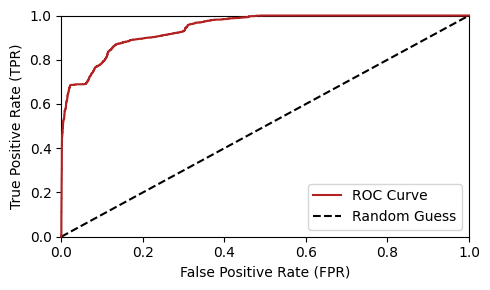

In [ ]:
import os
import numpy as np
from pyod.models.iforest import IForest
from sklearn.metrics import roc_auc_score

# Initialize and train the IF model
if_ = IForest(n_estimators=100, max_samples='auto', contamination=0.01)
if_.fit(X_train)

# Extract IF raw scores (higher score = more anomalous)
y_score = if_.decision_function(X_test)  # Raw anomaly scores

# Convert y_test to binary format if necessary (ensure it's 0 or 1)
y_test_binary = [0 if v == encoded_legit_class else 1 for v in y_test.astype(int)]

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_score)
print(f'ROC AUC Score: {roc_auc:.4f}')
roc_pauc = roc_auc_score(y_test_binary, y_score, max_fpr=0.01)
print(f'ROC Partial AUC Score: {roc_pauc:.4f}')

# Define the save path (modify `results_path` and `model_name` accordingly)
results_path = "./results"  # Change this to your preferred directory
model_name = "IF"
os.makedirs(results_path, exist_ok=True)

# Plot and save the ROC curve
plot_roc(
    y_test_binary,
    y_score,
    savefig=os.path.join(results_path, f'ROC_{model_name}')
)


# Anomaly Detection via Generative AI

## Variational AutoEncoder with pyOD

Training: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


ROC AUC Score: 0.9191
ROC Partial AUC Score: 0.5254


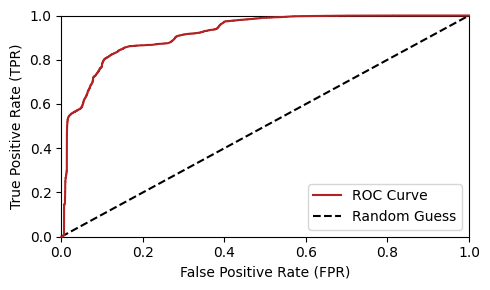

In [ ]:
import os
import numpy as np
from pyod.models.vae import VAE
from sklearn.metrics import roc_auc_score
import math

# Initialize and train the VAE model
vae = VAE(contamination=0.01, preprocessing=True, lr=0.01, epoch_num=10,
                  batch_size=128, optimizer_name='sgd', device=None, random_state=42,
                  use_compile=False, compile_mode='default', verbose=1,
                  optimizer_params={},
                  encoder_neuron_list=[
                      math.ceil(X_train.shape[1] * .75),
                      math.ceil(X_train.shape[1] * .5)],
                  decoder_neuron_list=[
                      math.ceil(X_train.shape[1] * .5),
                      math.ceil(X_train.shape[1] * .75)],
                  hidden_activation_name='relu')

vae.fit(X_train)

# Extract VAE raw scores (higher score = more anomalous)
y_score = vae.decision_function(X_test)  # Raw anomaly scores

# Convert y_test to binary format if necessary (ensure it's 0 or 1)
y_test_binary = [0 if v == encoded_legit_class else 1 for v in y_test.astype(int)]

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_score)
print(f'ROC AUC Score: {roc_auc:.4f}')
roc_pauc = roc_auc_score(y_test_binary, y_score, max_fpr=0.01)
print(f'ROC Partial AUC Score: {roc_pauc:.4f}')

# Define the save path (modify `results_path` and `model_name` accordingly)
results_path = "./results"  # Change this to your preferred directory
model_name = "VAE"
os.makedirs(results_path, exist_ok=True)

# Plot and save the ROC curve
plot_roc(
    y_test_binary,
    y_score,
    savefig=os.path.join(results_path, f'ROC_{model_name}')
)


In [ ]:
!pip install transformers datasets

from transformers import GPT2LMHeadModel, GPT2Config
import torch
import numpy as np


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 MB 8.7 MB/s eta 0:00:0000:0100:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 13.0.0
    Uninstalling pyarrow-13.0.0:
      Successfully uninstalled pyarrow-13.0.0


## GPT-2 with Huggingface

In [ ]:
class SimpleTokenizer:
    def __init__(self, token2id):
        self.token2id = dict(token2id)  # copia così non modifichiamo l'originale
        self.pad_token = '<PAD>'
        if self.pad_token not in self.token2id:
            self.pad_token_id = len(self.token2id)
            self.token2id[self.pad_token] = self.pad_token_id
        else:
            self.pad_token_id = self.token2id[self.pad_token]
        self.id2token = {v: k for k, v in self.token2id.items()}

    def encode(self, text, max_length=128, truncation=True, padding="max_length", return_tensors=None):
        tokens = text.split()
        token_ids = [self.token2id.get(t, self.pad_token_id) for t in tokens]

        if truncation and len(token_ids) > max_length:
            token_ids = token_ids[:max_length]
        pad_len = max_length - len(token_ids)
        if padding == "max_length":
            token_ids += [self.pad_token_id] * pad_len

        attention_mask = [1] * (max_length - pad_len) + [0] * pad_len

        import torch
        input_ids_tensor = torch.tensor([token_ids])
        attention_mask_tensor = torch.tensor([attention_mask])

        class Encoding:
            pass

        encoding = Encoding()
        encoding.input_ids = input_ids_tensor
        encoding.attention_mask = attention_mask_tensor
        return encoding

    def __call__(self, text, max_length=128, truncation=True, padding="max_length", return_tensors=None):
        return self.encode(text, max_length, truncation, padding, return_tensors)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(self.texts[idx], max_length=self.max_length, truncation=True, padding="max_length", return_tensors="pt")
        input_ids = encoded.input_ids.squeeze(0)
        attention_mask = encoded.attention_mask.squeeze(0)
        return input_ids, attention_mask

class GPT2Detector:
    def __init__(self, token2id):
        # Costruiamo tokenizer con il pad incluso
        self.tokenizer = SimpleTokenizer(token2id)
        vocab_size = len(self.tokenizer.token2id)  # ora è già corretto

        config = GPT2Config(
            n_embd=32,
            n_layer=2,
            n_head=2,
            vocab_size=vocab_size,
            pad_token_id=self.tokenizer.pad_token_id  # meglio specificarlo
        )
        self.model = GPT2LMHeadModel(config)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.train()

    def fit(self, X_train, y_train=None, epochs=10, batch_size=8, lr=5e-5):
        # Dataset e DataLoader
        dataset = TextDataset(X_train, self.tokenizer)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        loss_fn = torch.nn.CrossEntropyLoss(ignore_index=self.tokenizer.pad_token_id)

        for epoch in range(epochs):
            total_loss = 0
            self.model.train()
            for input_ids, attention_mask in dataloader:
                input_ids = input_ids.to(self.device)
                attention_mask = attention_mask.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=input_ids)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(dataloader)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    def predict_score(self, X):
        self.model.eval()
        scores = []
        for text in X:
            encoding = self.tokenizer(text, return_tensors='pt', truncation=True)
            input_ids = encoding.input_ids.to(self.device)
            with torch.no_grad():
                outputs = self.model(input_ids, labels=input_ids)
                loss = outputs.loss
            perplexity = torch.exp(loss).item()
            scores.append(perplexity)
        return np.array(scores)

In [ ]:
def tabular_to_text(X):
    # Converte riga numpy array in stringa con valori numerici separati da spazi
    texts = []
    for row in X:
        text = " ".join([str(round(x, 4)) for x in row])
        texts.append(text)
    return texts


In [ ]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
def build_vocab(texts):
    vocab = set()
    for text in texts:
        tokens = text.split()
        vocab.update(tokens)
    token2id = {token: idx for idx, token in enumerate(sorted(vocab))}
    return token2id, len(vocab)

# Esempio:
X_train_text = tabular_to_text(X_train)
token2id, vocab_size = build_vocab(X_train_text)
print(f"Vocabolario custom size: {vocab_size}")


Vocabolario custom size: 2087


Trainable parameters: 125056


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1/10 - Loss: 1.3472
Epoch 2/10 - Loss: 0.2451
Epoch 3/10 - Loss: 0.2152
Epoch 4/10 - Loss: 0.2016
Epoch 5/10 - Loss: 0.1930
Epoch 6/10 - Loss: 0.1871
Epoch 7/10 - Loss: 0.1827
Epoch 8/10 - Loss: 0.1793
Epoch 9/10 - Loss: 0.1766


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 10/10 - Loss: 0.1742


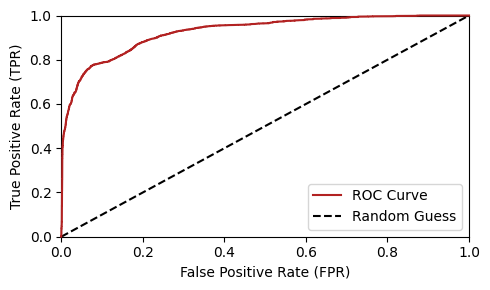

In [ ]:
# Istanzia modello
gpt2_detector = GPT2Detector(token2id)

num_params = count_trainable_parameters(gpt2_detector.model)
print(f"Trainable parameters: {num_params}")

# Prepara dati testo da array numerico
X_train_text = tabular_to_text(X_train)
X_test_text = tabular_to_text(X_test)

# Addestra 10 epoche
gpt2_detector.fit(X_train_text, epochs=10, batch_size=8, lr=5e-5)

# Calcola scores perplexity su test
anom_scores = gpt2_detector.predict_score(X_test_text)

# Usa la funzione plotroc già presente
plot_roc(y_test_binary, anom_scores, savefig=None, show=True)